# Final Project (Project 04)
**Anh Nguyen**
* UnityID: anguyen9

**Note: This project is submitted for competition**

In [22]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt
import convolution as conv
import blob_detection as Blobs
import time
import utils
from IPython.display import display, Image

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Notes:** 
* The ```results``` folder contains several test results of the implementation on different images using different sigma, scale and threshold.  However, in this workflow, I only show how the code works on one image using ```sigma = 2; k = 1.41; threshold = 0.0004``` for simplicity
* ```results``` folder contains a text file detailing the sigma, scale, and threshold used to get each result in the folder

**Required packages**
* ```skimage```
* ```scipy```
* ```OpenCV2``` - the code does not directly use any ```cv2``` function; however, the program is dependent on the ```utils.py``` for helper functions and this module has functions that use ```cv2```.  As a result, ```OpenCV2``` is needed
* ```matplotlib.pyplot```
* ```convolution.py``` - external module implemented by me
* ```DFT.py``` - external module implemented by me
* ```paddings.py``` - external module implemented by me
* ```itertools.combinations``` 

### To run the code
* Use the following usage (can always type ```python blob_detection.py -h``` in terminal for instruction)
* an example of commandline command and its runtime are also included below

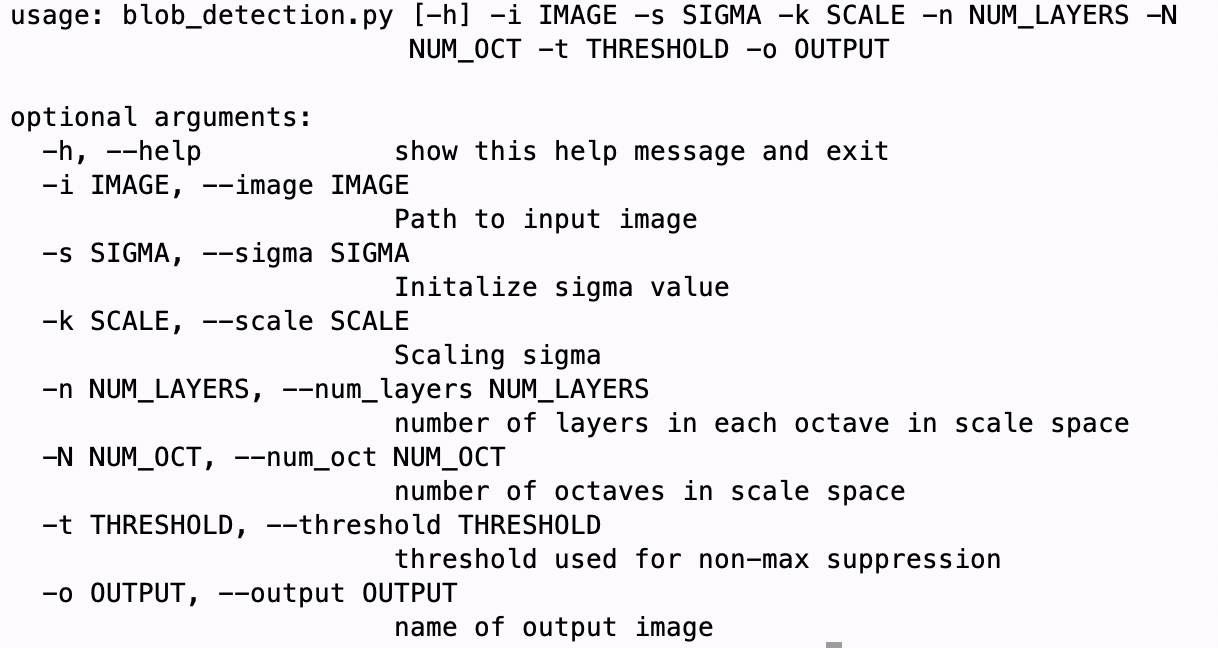

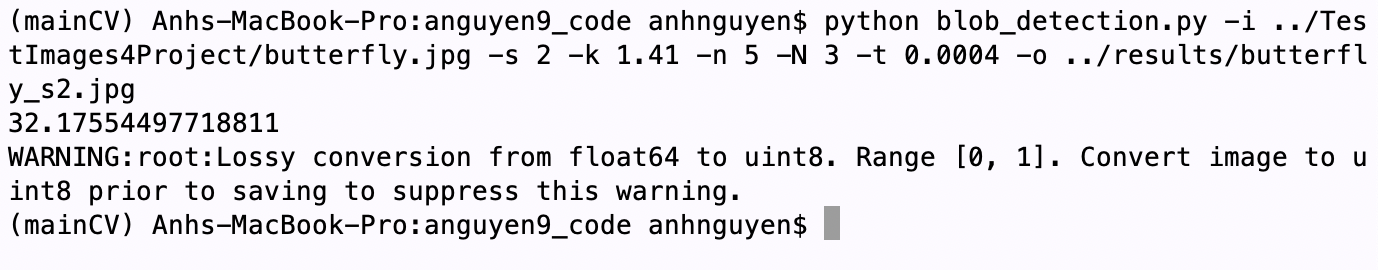

In [7]:
display(Image(filename="../demonstration/blob_detection_usage.png"))
display(Image(filename="../demonstration/commandline.png"))

The following sample image will be used to demonstrate how the code works in the ```Implementation``` section below

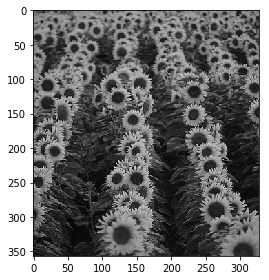

In [10]:
image = io.imread("../TestImages4Project/sunflowers.jpg")
image = color.rgb2gray(image)  # convert to normalized (range [0,1]) grayscale image
io.imshow(image)

## Implementation

**Generation of Laplacian of Gaussian (LoG) filter**
* Following the implementation of extracting distinctive invariant features from images presented by David Lowe in his study, *"Distinctive Image Features from Scale-Invariant Keypoints"* (Lowe, 2004), instead of generating a Laplacian of Gaussian filter using a Laplacian filter and repeatedly filter smooth version of image with different sigma, I approximate LoG using difference of Gaussian (DoG)

**Build Laplacian scale space**
* DoG is implemented following closely scale space representation detailed in Lowe's paper.  Below is the presentation of the scale space as mentioned in Lowe's paper.  My code used this presentation

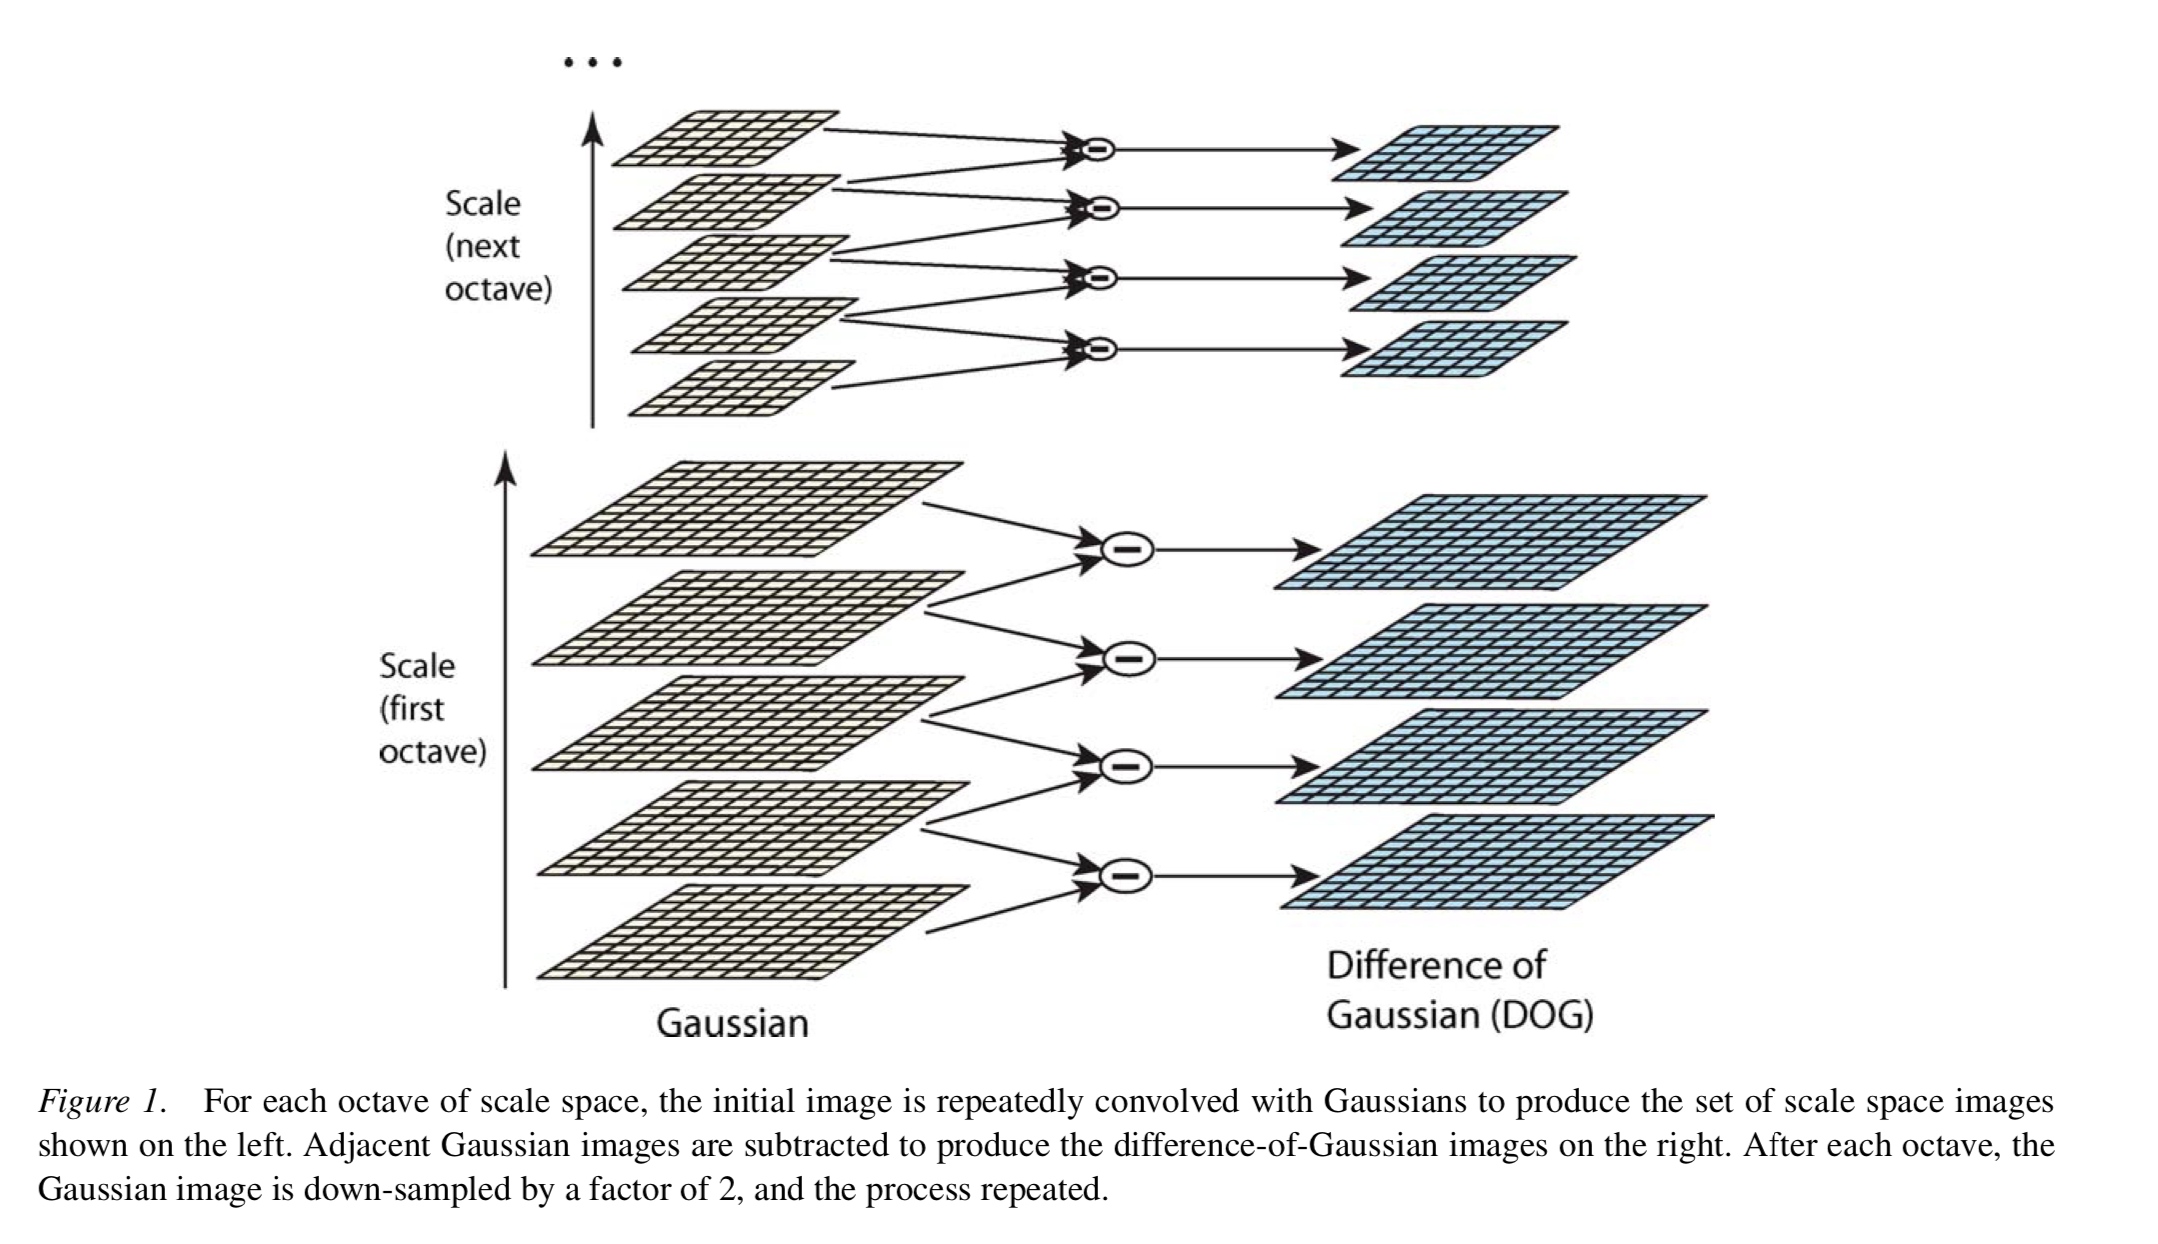

In [11]:
display(Image("../demonstration/scale_space.png"))

* Within each octave, the number of DoG layers is determined by user.  The bottom of the first Gaussian octave is original image smoothed using a Gaussian filter with sigma value given by user.  The sigmas of smoothing kernels of succeeding layer are increase by scaling constant (k) given by user.  The bottom layer of Gaussian uses kernel with initial sigma, the second layer uses kernel with ``k*sigma``, the third layer use kernel with ``(k^2)*sigma``, and so on.
* DoG octave is obtained by subtracting the previous layer from the current layer
* Bottom layer of the next Gaussian octave is obtained by (1) downsampling the original image with ```downscale = 1/2``` and (2) smoothing the downsampled image with the new standard deviation that is twice the standard deviation of the previous octave. (**note** gaussian kernel used to smooth image before downscaling always have ```sigma = 2```)
* the DoG was squared so I have positive results and peaks can be found by looking for maximum instead of looking for maximum and minimum

**Below is the DoG approximation of Laplacian scale space**

/Users/anhnguyen/anaconda3/envs/mainCV/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


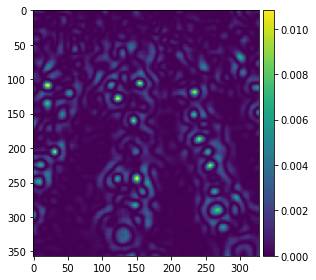

In [16]:
# sigma = 2; k = 1.41; number of layer in each octave = 5; number of octave in scale space = 3
# the displayed image is the DoG (approximation of LoG) with sigma = (1.41^2) * 2 in the first octave
sigma = 2; k = 1.41; num_layers = 5; num_oct = 3
space, sigmas = Blobs.build_scale_space(image, sigma, k, num_layers, num_oct)
io.imshow(space[0][:,:,3])

**Non-maximum suppression**
* Weak signals response, whose value is close to 0 but not quite, presents difficulty when looking for true extrema and slow down the process of non-maximum suppression.  As a result, extrema of DoG are found by (1) remove/suppress signals whose values are 0.25 or less after response signals are normalized to fit in range [0, 1]; and (2) compare leftover pixel signals to 8 neighboring pixels within the layer and 18 neighboring pixels in the layer above and below (9 pixels at each layer); if the pixel is greater than all 26 of the neighboring pixels, it's considered to be an extremum

Below is visual representation of the above process

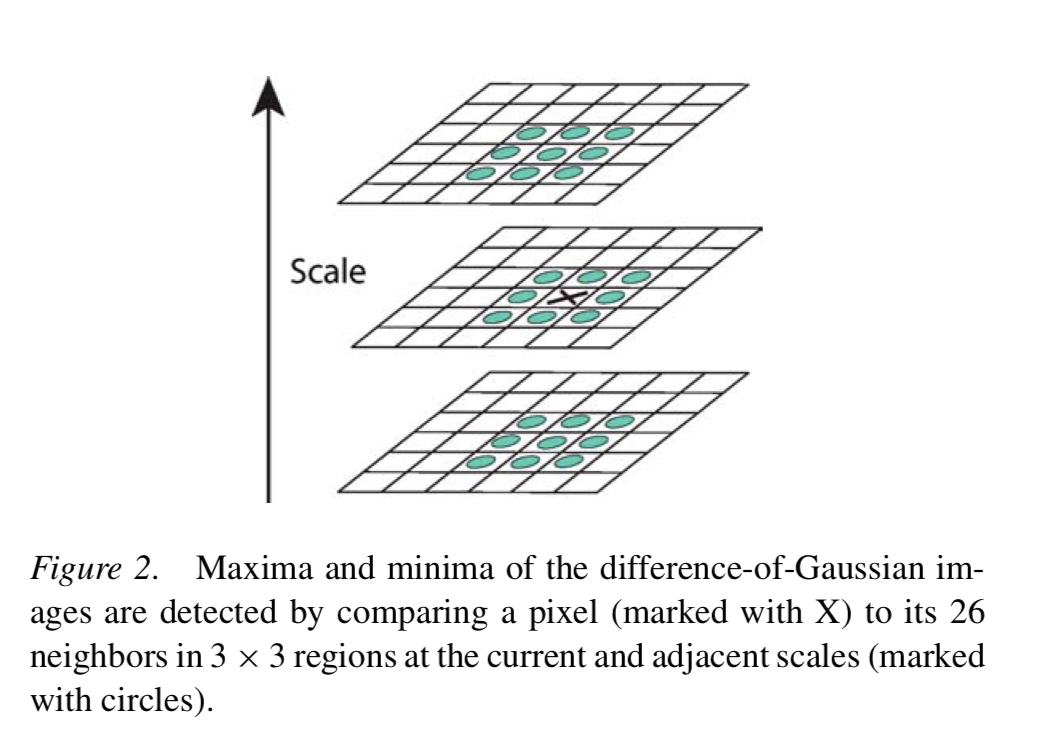

In [31]:
display(Image(filename="../demonstration/extrema_detection.png"))

* extrema are centers of blobs.  To further suppress trivial responses, intersection area of near by blobs are compared to the total area of the two blobs; if **intersection-over-union** area is too large (compared to the threshold given by user), blob with weaker center signals is removed
* signals remained after non-maximum suppression are truee blobs centers.  The radii of these blobs are ```r = sigma * square_root(2)```.  The extrema found in subsequent octaves are projected onto the original image and their radii are further scaled by a factor of 2 (since images in subsequent octaves are downsampled by a downscale of 2)
* Since sigmas used between octaves are considerably different, non-maximum suppression is only performed within octave and layers and not accross octaves
* Before performing non-maximum suppression, extrema are sorted in increasing order using radii.
* Calculation of intersection area is vectorized for speed.  In addition, dictionary was used to store true extrema for fast lookup and update

Below is the result of blobs after non-maximum suppression

In [34]:
threshold = 0.0004
peaks = Blobs.find_peaks(space, sigmas, threshold)
result = image.copy()
result = color.gray2rgb(result)
projected_peaks = []
for i in range(num_oct):
    img_scale = 2**i
    octave_peaks = list(peaks[i].values())
    projected_peaks += Blobs.project_points(image, img_scale, octave_peaks)

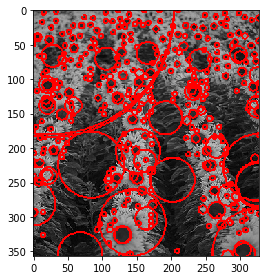

In [35]:
utils.draw_circles(result, projected_peaks)
io.imshow(result)